In [39]:
import numpy as np
import matplotlib.pyplot as plt

import webbpsf
from statsmodels.regression.linear_model import WLS

from lenstronomy.Data.psf import PSF
from lenstronomy.Util import util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.io import fits
from astropy.table import Table
from uncertainties import unumpy as unp
from uncertainties import ufloat
from grizli import utils
from astropy import wcs as pywcs

import pandas as pd
from astropy.convolution import convolve
from make_diagnostic_maps import bin_2D
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=69.5, Om0=0.285, Ob0=0.0461)

import emcee
from scipy.optimize import minimize
import corner

## Reading in the data

In [3]:
root_path = '/Users/acharyya/Work/astro/passage/'
field = 'Par028'
objid = 2867
re_limit = 2.5
Zdiag = 'NB'
filter_in_full_fits = 'F140W'

supersampling_factor = 1
fov_arcsec = 0.67
exptime = 500
filter = 'F150W'

In [29]:
survey = 'passage' if 'Par' in field else 'glass'
full_fitsname = root_path + f'/{survey}_data/v0.5/{field}/Products/maps/{field}_{objid:05d}.maps.fits'
full_hdu = fits.open(full_fitsname)
hdu = full_hdu['DSCI', filter_in_full_fits]
filter_image = hdu.data
pixel_scale = utils.get_wcs_pscale(pywcs.WCS(full_hdu['DSCI'].header))
z = full_hdu[0].header['redshift']

In [57]:
metallicity_fitsname = root_path + f'/{survey}_output/v0.5/catalogs/{field}_{objid:05d}_logOH_map_upto_{re_limit}re_onlyseg_vorbin_at_OII_SNR_3.0_Zdiag_{Zdiag}.fits'
hdul = fits.open(metallicity_fitsname)
hdu = hdul['log_OH']
logOH_map = np.ma.masked_where(np.isnan(hdu.data), unp.uarray(hdu.data, hdul['log_OH_u'].data))
logOH_map.data[np.isnan(unp.nominal_values(logOH_map.data))] = ufloat(0, 1e20)

logOH_df = Table(hdul['tab'].data).to_pandas()
logOH_df['distance'] *= cosmo.arcsec_per_kpc_proper(z).value # converting from kpc to arcsec

center_pix = int(np.shape(filter_image)[0] / 2)
farthest_pix = int(np.shape(logOH_map)[0] / 2)
light_map = filter_image[center_pix - farthest_pix : center_pix + farthest_pix, center_pix - farthest_pix : center_pix + farthest_pix]

## Use case #1: Forward-modelling the effects of psf smear

We can attempt to fit the metallicity gradient for this galaxy using weighted least squares (WLS) and the observed metallicity profile, but it won't be correct:

In [48]:
# First, find the radial distance from each pixel to the galaxy's center
x        = np.arange(np.shape(logOH_map)[0])
y        = np.arange(np.shape(logOH_map)[1])
X, Y     = np.meshgrid(x, y)
gal_cen  = np.shape(logOH_map)[0]/2
R_pix    = np.sqrt( (X - gal_cen)**2 + (Y - gal_cen)**2 )
R_arcsec = R_pix * pixel_scale

# Using this, construct the covariate matrix for a linear model
flat_R     = R_arcsec.flatten()
covariates = np.vstack((np.ones(len(flat_R)), flat_R)).T

# Weight each pixel by the inverse variance of the measured metallicity
flat_weights = (1 / unp.std_devs(logOH_map.data) ** 2).flatten()

flat_data = unp.nominal_values(logOH_map).flatten()

# Fit a model
wls_model_fit = WLS(flat_data, covariates, weights=flat_weights).fit()

print(wls_model_fit.summary())

print("\nRecovered Zc = {0:.5}, gradZ = {1:.5}.".format(*wls_model_fit.params))

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.449
Model:                            WLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     157.8
Date:                Thu, 29 May 2025   Prob (F-statistic):           7.22e-27
Time:                        17:36:07   Log-Likelihood:                -5996.0
No. Observations:                 196   AIC:                         1.200e+04
Df Residuals:                     194   BIC:                         1.200e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7360      0.060    129.618      0.0

In [ ]:
# ---------making the PSF---------------
niriss = webbpsf.NIRISS()
niriss.filter = filter
niriss.pixelscale = pixel_scale
psf = niriss.calc_psf(fov_arcsec=fov_arcsec, oversample=supersampling_factor)
psf_array  = psf[0].data
psf_type   = 'PIXEL'
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source':psf_array, 'point_source_supersampling_factor':supersampling_factor}

# --------generate the coordinate grid and image properties (we only read out the relevant lines we need)-----------
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=np.shape(logOH_map)[0], deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

# ---------reading in observed light map-----------------------------
kwargs_image_data = {'background_rms':.005 ,  # rms of background noise; background noise per pixel
                    'exposure_time': exptime,  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
                    'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                    'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                    'image_data': light_map   # 2d data vector
                    }

# ---------reading in observed metallicity map-----------------------------
kwargs_tracer_data = {'noise_map': unp.std_devs(logOH_map.data),
                    'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                    'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                    'image_data': unp.nominal_values(logOH_map.data)}  # 2d data vector


We can visualise this galaxy's image and metallicity map:

Text(0.5, 1.0, 'PSF')

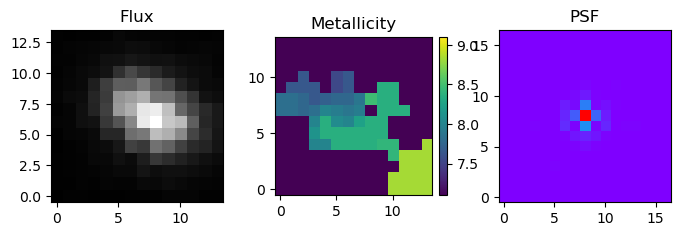

In [14]:
fig, axes = plt.subplots(1,3, figsize=(8, 3))
fig.subplots_adjust(wspace=0.3)
axes[0].imshow(kwargs_image_data['image_data'], cmap='Greys_r')
axes[0].set_title('Flux')
z_plot = axes[1].imshow(kwargs_tracer_data['image_data'], vmin=7.1, vmax=9.1)
axes[1].set_title('Metallicity')
plt.colorbar(z_plot,ax=axes[1],fraction=0.046, pad=0.04)
axes[2].imshow(kwargs_psf['kernel_point_source'], cmap='rainbow')
axes[2].set_title('PSF')

On the other hand, we can fit the metallicity gradient using forward-modelling with `lenstronomy`'s tracer module, for a much more accurate result:  
(expected run time: ~5 minutes. Make yourself a cup of tea!)

In [35]:
# ---------defining numeric kwargs-----------------------------
kwargs_numerics = {'supersampling_factor':supersampling_factor, 
                'point_source_supersampling_factor':supersampling_factor, 
                'supersampling_convolution': True}

# ---------defining lens model-----------------------------
lens_params = [[], [], [], [], []] # Since our model is no lens, use a bunch of empty lists

# ---------defining source model params-----------------------------
# Source params -- fixed to true input values; We know that lenstronomy can fit galaxy properties, we are not testing this here.
fixed_source        = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_init  = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_sigma = [{'amp': 1,  'R_sersic': 1, 'n_sersic': 1, 'e1': 1, 'e2': 1, 'center_x': 1, 'center_y': 1}]
kwargs_lower_source = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_upper_source = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# ---------defining tracer model params-----------------------------
fixed_tracer_source = [{'center_x': 0, 'center_y': 0}]
kwargs_tracer_source_init  = [{'center_x': 0, 'center_y': 0, 'amp': 8, 'k': 0}] 
kwargs_tracer_source_sigma = [{'center_x': 2, 'center_y': 2, 'amp': 0.5, 'k': 0.3}]
kwargs_lower_tracer_source = [{'center_x': -10, 'center_y': -10, 'amp': 6,   'k': -1}]
kwargs_upper_tracer_source = [{'center_x': 10, 'center_y': 10, 'amp': 9,   'k': +1}]

tracer_source_params = [kwargs_tracer_source_init, kwargs_tracer_source_sigma, fixed_tracer_source, kwargs_lower_tracer_source, kwargs_upper_tracer_source]

# ---------combing all models-----------------------------
kwargs_params = {'lens_model': lens_params, 'source_model': source_params, 'tracer_source_model': tracer_source_params}           
kwargs_likelihood = {'source_marg': False, 'tracer_likelihood': True}
kwargs_model = {'lens_model_list': [], 'source_light_model_list': ['SERSIC_ELLIPSE'],  'tracer_source_model_list': ['LINEAR'], 'tracer_source_band': 0, 'tracer_partition':[[0,0]]}

# ---------fitting process-----------------------------
multi_band_list = [[kwargs_image_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                'multi_band_type': 'single-band',  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                'tracer_data': [kwargs_tracer_data, kwargs_psf, kwargs_numerics]}
kwargs_constraints = {'linear_solver': True}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO',  {'sigma_scale': 1, 'n_particles': 100, 'n_iterations': 100}], ['MCMC', {'n_burn': 50, 'n_run': 200, 'n_walkers': 100, 'sigma_scale': .1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

print(kwargs_result)

Computing the PSO ...


100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


Max iteration reached! Stopping.
-6.961760727135001 reduced X^2 of best position
-1354.0624614277576 log likelihood
389.0 effective number of data points
[] lens result
[{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}] source result
[] lens light result
[] point source result
[{'amp': 8.215125191538286, 'k': 0.9999999996339772, 'center_x': 0, 'center_y': 0}] tracer source result
{} special param result
5.291853189468384 time used for  PSO
MCMC selected. Sampling with default option emcee.


100%|██████████| 250/250 [00:17<00:00, 13.90it/s]

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  50
Sampling iterations (in current run): 250
18.090744018554688 time taken for MCMC sampling
{'kwargs_lens': [], 'kwargs_source': [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': [{'amp': 8.21591195572664, 'k': 0.9999811747426465, 'center_x': 0, 'center_y': 0}]}


Much better! From the posteriors of our emcee chain we can get credible intervals and formal uncertainties on these fitted parameters, too:

In [16]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

lower_bound = np.percentile(samples_mcmc[:,1], 16)
median      = np.percentile(samples_mcmc[:,1], 50)
upper_bound = np.percentile(samples_mcmc[:,1], 84)

print("gradZ = {0:.4} (+{1:.4}/-{2:.4})".format(median, upper_bound - median, median-lower_bound))

gradZ = 0.9839 (+0.01185/-0.02651)


## Now my method of MCMC on voronoi bins

In [ ]:
# -------making the ideal metallicity map (model)-----------------
kwargs_init = [{'center_x': 0, 'center_y': 0, 'slope': -0.5, 'cen': 8}]
kwargs_sigma = [{'center_x': 1, 'center_y': 1, 'slope': 0.5, 'cen': 1}]
kwargs_lower = [{'center_x': 0, 'center_y': 0, 'slope': 2, 'cen': 6}]
kwargs_upper = [{'center_x': 0, 'center_y': 0, 'slope': -2, 'cen': 9}]
radprof = [kwargs_init[0]['slope'], kwargs_init[0]['cen']]

center_pix = np.shape(logOH_map)[0] / 2.
distance_map = np.array([[np.sqrt((i - center_pix)**2 + (j - center_pix)**2) for j in range(np.shape(logOH_map)[1])] for i in range(np.shape(logOH_map)[0])]) * pixel_scale # arcsec
logOH_map_model = np.poly1d(radprof)(distance_map)

# ------smoothing metallicity model with PSF------------------
logOH_map_model_smoothed = convolve(logOH_map_model, psf_array)

# -------voronoi binning the smoothed map as per given vorbin segmentation----------
bin_IDs_map = hdul['bin_id'].data
bin_IDs_map = np.ma.masked_where(np.isnan(bin_IDs_map), bin_IDs_map)

logOH_map_model_smoothed = bin_2D(logOH_map_model_smoothed, bin_IDs_map)
logOH_map_model_smoothed.data[logOH_map_model_smoothed.mask] = np.nan
logOH_df_model = pd.DataFrame({'distance': distance_map.flatten(), 'log_OH_model': logOH_map_model_smoothed.data.flatten(), 'bin_ID': bin_IDs_map.data.flatten().byteswap().newbyteorder()})
logOH_df_model = logOH_df_model.dropna().reset_index(drop=True)
logOH_df_model['bin_ID'] = logOH_df_model['bin_ID'].astype(int)
logOH_df_model = logOH_df_model.groupby(['bin_ID'], as_index=False).agg(np.mean)

In [42]:
def log_likelihood(params, x, y, yerr):
    radprof = [params[0], params[1]]
    log_f = params[2]

    center_pix = np.shape(logOH_map)[0] / 2.
    distance_map = np.array([[np.sqrt((i - center_pix)**2 + (j - center_pix)**2) for j in range(np.shape(logOH_map)[1])] for i in range(np.shape(logOH_map)[0])]) * pixel_scale # arcsec
    logOH_map_model = np.poly1d(radprof)(distance_map)

    # ------smoothing metallicity model with PSF------------------
    logOH_map_model_smoothed = convolve(logOH_map_model, psf_array)

    # -------voronoi binning the smoothed map as per given vorbin segmentation----------
    bin_IDs_map = hdul['bin_id'].data
    bin_IDs_map = np.ma.masked_where(np.isnan(bin_IDs_map), bin_IDs_map)

    logOH_map_model_smoothed = bin_2D(logOH_map_model_smoothed, bin_IDs_map)
    logOH_map_model_smoothed.data[logOH_map_model_smoothed.mask] = np.nan
    logOH_df_model = pd.DataFrame({'distance': distance_map.flatten(), 'log_OH_model': logOH_map_model_smoothed.data.flatten(), 'bin_ID': bin_IDs_map.data.flatten().byteswap().newbyteorder()})
    logOH_df_model = logOH_df_model.dropna().reset_index(drop=True)
    logOH_df_model['bin_ID'] = logOH_df_model['bin_ID'].astype(int)
    logOH_df_model = logOH_df_model.groupby(['bin_ID'], as_index=False).agg(np.mean)
    logOH_df_model = logOH_df_model.drop('bin_ID', axis=1)

    temp_df = pd.DataFrame({'distance': x, 'log_OH_obs': y, 'log_OH_obs_u': yerr}) 
    logOH_df_merged = temp_df.merge(logOH_df_model, on=['distance'])

    model = logOH_df_merged['log_OH_model']
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    log_like = -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

    return log_like

In [ ]:
x = logOH_df['distance']
y = logOH_df['log_OH']
yerr = logOH_df['log_OH_u']

f_init = 0.1
params_init = [kwargs_init[0]['slope'], kwargs_init[0]['cen'], np.log(f_init)]
ndim = len(params_init)
nwalkers = 32
niter = 200

[ 7.74385166  7.38863387 -3.74987919]


In [ ]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array(params_init)
soln = minimize(nll, initial, args=(x, y, yerr))
print(soln.x)

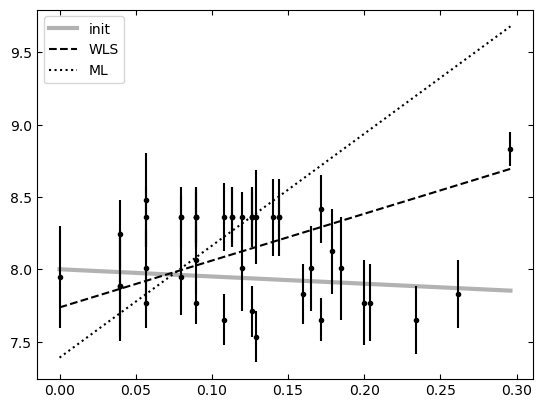

In [ ]:
xarr = np.linspace(np.min(x), np.max(x), 10)

plt.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0)
plt.plot(xarr, np.poly1d([params_init[0], params_init[1]])(xarr), 'k', alpha=0.3, lw=3, label='init')
plt.plot(xarr, np.poly1d([wls_model_fit.params[1], wls_model_fit.params[0]])(xarr), '--k', label='WLS')
plt.plot(xarr, np.poly1d([soln.x[0], soln.x[1]])(xarr), ':k', label='ML')
plt.legend()

In [62]:
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, y, yerr))
sampler.run_mcmc(pos, niter, progress=True)

100%|██████████| 500/500 [05:20<00:00,  1.56it/s]


State([[ 5.07265803  7.79831637 -3.66610642]
 [ 7.75179348  7.33817075 -3.68329006]
 [ 4.99329038  7.77312892 -3.59918433]
 [ 8.05125264  7.33492774 -3.81757998]
 [ 7.74595614  7.34027732 -3.6778737 ]
 [ 7.25062506  7.44916268 -3.62357998]
 [ 8.65427451  7.22189352 -3.74480823]
 [ 7.69783782  7.43273514 -3.9515575 ]
 [ 6.83407535  7.50595743 -4.05317069]
 [ 6.46486976  7.60296508 -3.66414102]
 [ 8.46873757  7.28490642 -4.46885258]
 [ 5.71975066  7.682783   -3.77147734]
 [ 7.54925686  7.41947731 -3.54737398]
 [ 2.41347724  8.0960764  -3.86116792]
 [ 7.3467295   7.48600298 -3.65572223]
 [ 9.39266584  7.13138316 -3.94117644]
 [ 6.85571394  7.5445978  -3.59560045]
 [ 8.42108226  7.26125737 -3.94321204]
 [10.22665178  7.1011653  -3.31714361]
 [ 5.97708532  7.67296227 -3.56903951]
 [ 8.17131561  7.33741854 -3.55026875]
 [ 8.04022893  7.3815738  -3.58871656]
 [ 6.24121634  7.59705616 -3.41960998]
 [ 4.66662426  7.70181119 -3.76924988]
 [ 6.91515534  7.4118972  -3.88650987]
 [ 7.51855955  7.46

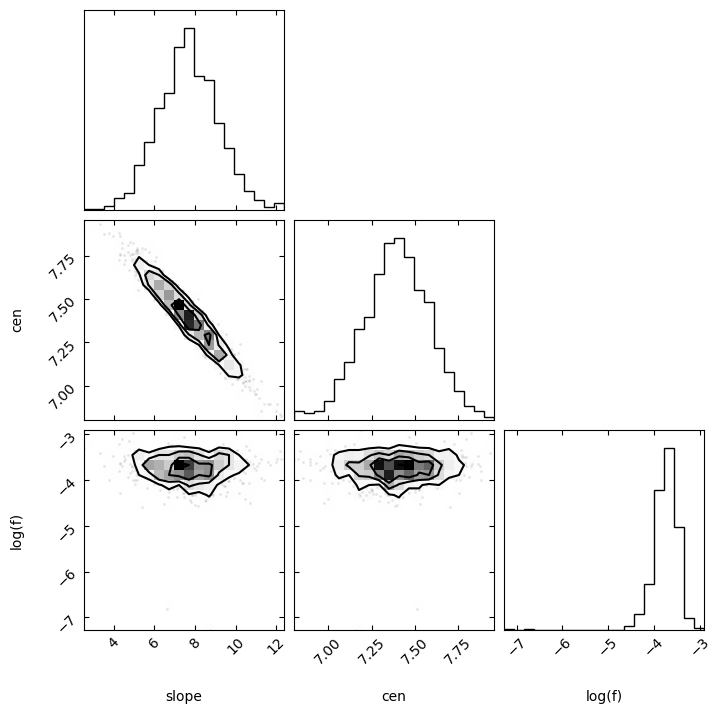

In [63]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ['slope', 'cen', 'log(f)']
fig = corner.corner(flat_samples, labels=labels, truths=params_init)